# Veri Setinin Yüklenmesi ve Hazırlanması

Bu bölümde Kaggle Garbage Classification veri seti yüklenmiş ve eğitim (training) ile doğrulama (validation) alt kümelerine ayrılmıştır.  
Görüntüler 128×128 boyutuna ölçeklenmiş ve batch halinde modele beslenmiştir.  
`validation_split=0.2` kullanılarak veri seti otomatik olarak %80 eğitim ve %20 doğrulama olacak şekilde bölünmüştür.


In [1]:
import pathlib
import tensorflow as tf

DATA_DIR = pathlib.Path("data/garbage")
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
SEED = 42

train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

class_names = train_ds.class_names
num_classes = len(class_names)

print("Classes:", class_names)
print("Num classes:", num_classes)


c:\Users\memet\anaconda3\envs\nnfinal\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


Found 2527 files belonging to 6 classes.
Using 2022 files for training.
Found 2527 files belonging to 6 classes.
Using 505 files for validation.
Classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
Num classes: 6


# Veri Akışı Optimizasyonu

Bu bölümde veri yükleme performansını artırmak amacıyla `cache`, `shuffle` ve `prefetch` işlemleri uygulanmıştır.  
Bu optimizasyonlar, GPU/CPU kullanımını iyileştirerek eğitim süresini kısaltır.


In [2]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)


# Veri Seti Kontrolü (Sanity Check)

Bu bölümde doğrulama veri setinden örnek görüntüler görselleştirilerek,  
verilerin doğru sınıflara ait olup olmadığı ve yükleme işleminin düzgün çalışıp çalışmadığı kontrol edilmiştir.


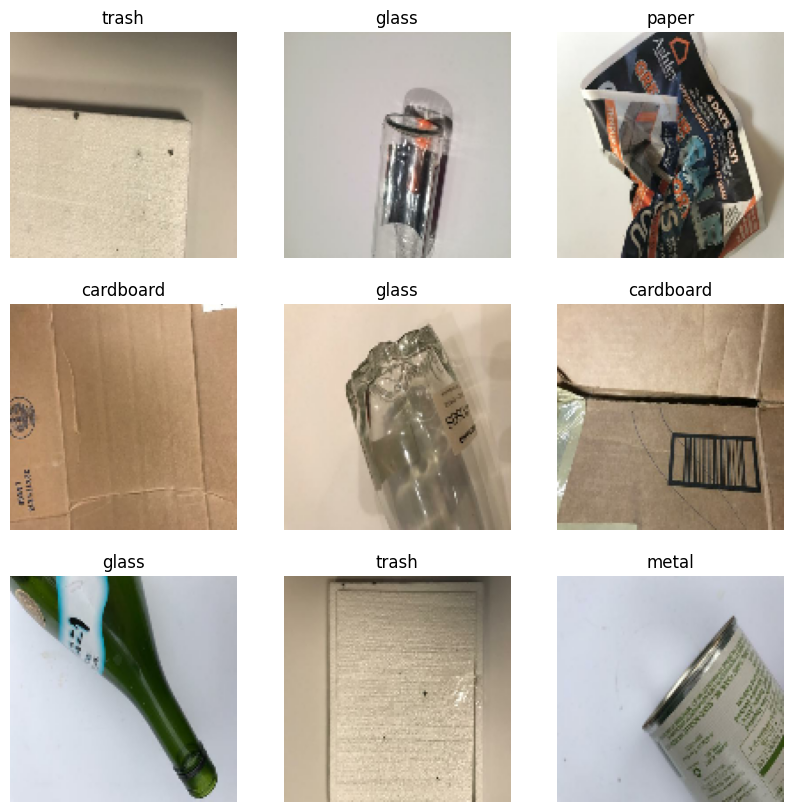

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for images, labels in val_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()


# CNN Model Mimarisi

Bu bölümde sıfırdan bir Evrişimli Sinir Ağı (CNN) mimarisi oluşturulmuştur.  
Model; evrişim (Conv2D), havuzlama (MaxPooling), dropout ve tam bağlantılı (Dense) katmanlardan oluşmaktadır.  
Ayrıca genelleme başarısını artırmak amacıyla hafif veri artırma (data augmentation) uygulanmıştır.


In [4]:
from tensorflow import keras
from tensorflow.keras import layers, regularizers

# Hafif augmentation (contrast yok!)
data_aug = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.10),
])

model = keras.Sequential([
    layers.Input(shape=(128, 128, 3)),
    data_aug,
    layers.Rescaling(1./255),

    layers.Conv2D(32, 3, activation="relu"),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, activation="relu"),
    layers.MaxPooling2D(),

    layers.Conv2D(128, 3, activation="relu"),
    layers.MaxPooling2D(),

    layers.Dropout(0.30),

    layers.Flatten(),
    layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(1e-4)),
    layers.Dropout(0.40),
    layers.Dense(num_classes, activation="softmax")
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
model.summary()




Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,414 (12.61 MB)

 Trainable params: 3,305,414 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

# Model Eğitimi

Bu bölümde model, eğitim veri seti üzerinde eğitilmiş ve doğrulama veri seti ile değerlendirilmiştir.  
Overfitting’i önlemek amacıyla EarlyStopping ve ReduceLROnPlateau callback’leri kullanılmıştır.


In [6]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=4,
        restore_best_weights=True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        patience=2,
        factor=0.5,
        verbose=1
    ),
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,   # üst sınır
    callbacks=callbacks
)


Epoch 1/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 15s 196ms/step - accuracy: 0.2784 - loss: 1.7060 - val_accuracy: 0.3208 - val_loss: 1.5667 - learning_rate: 0.0010
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 12s 181ms/step - accuracy: 0.3591 - loss: 1.5855 - val_accuracy: 0.3960 - val_loss: 1.4670 - learning_rate: 0.0010
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 12s 180ms/step - accuracy: 0.4238 - loss: 1.4466 - val_accuracy: 0.4792 - val_loss: 1.3002 - learning_rate: 0.0010
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 11s 178ms/step - accuracy: 0.4812 - loss: 1.3225 - val_accuracy: 0.4356 - val_loss: 1.3804 - learning_rate: 0.0010
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 11s 179ms/step - accuracy: 0.4936 - loss: 1.3307 - val_accuracy: 0.5010 - val_loss: 1.2065 - learning_rate: 0.0010
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 11s 180ms/step - accuracy: 0.5317 - loss: 1.2610 - val_accuracy: 0.5386 - val_loss: 1.1661 - learning_rate: 0.0010
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 11s 179ms/step - accuracy: 0.5351 - loss: 1.

# Eğitim Sonuçlarının Görselleştirilmesi

Bu bölümde modelin eğitim sürecindeki doğruluk (accuracy) ve kayıp (loss) değerleri grafikler ile gösterilmiştir.  
Bu grafikler, modelin öğrenme davranışını ve overfitting durumunu analiz etmek için kullanılmıştır.


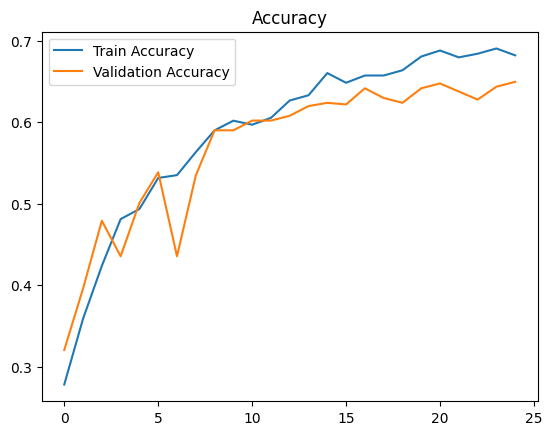

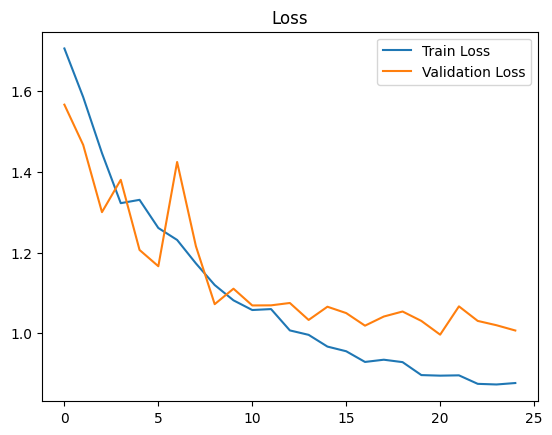

In [7]:
import matplotlib.pyplot as plt

# Accuracy
plt.figure()
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.legend()
plt.title("Accuracy")
plt.savefig("images/accuracy.png", dpi=200, bbox_inches="tight")
plt.show()

# Loss
plt.figure()
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.title("Loss")
plt.savefig("images/loss.png", dpi=200, bbox_inches="tight")
plt.show()


# Model Performans Analizi

Bu bölümde doğrulama veri seti üzerinde sınıflandırma raporu (precision, recall, f1-score) ve confusion matrix hesaplanmıştır.  
Bu analizler, modelin sınıf bazlı performansını değerlendirmek amacıyla yapılmıştır.


In [8]:
import numpy as np
from sklearn.metrics import classification_report

y_true, y_pred = [], []

for images, labels in val_ds:
    preds = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

print(classification_report(y_true, y_pred, target_names=class_names))


              precision    recall  f1-score   support

   cardboard       0.87      0.78      0.82        69
       glass       0.56      0.54      0.55       102
       metal       0.57      0.64      0.60        88
       paper       0.67      0.80      0.73       123
     plastic       0.71      0.56      0.63        89
       trash       0.47      0.41      0.44        34

    accuracy                           0.65       505
   macro avg       0.64      0.62      0.63       505
weighted avg       0.65      0.65      0.65       505



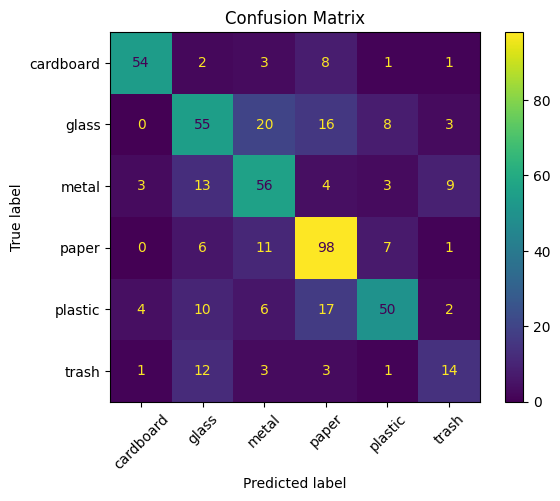

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(xticks_rotation=45, values_format="d")
plt.title("Confusion Matrix")
plt.savefig("images/confusion_matrix.png", dpi=200, bbox_inches="tight")
plt.show()


# En İyi Epoch’un Belirlenmesi

Bu bölümde doğrulama kaybı (val_loss) en düşük olan epoch belirlenmiş  
ve modelin en iyi performans gösterdiği nokta raporlanmıştır.


In [10]:
import numpy as np

best_epoch = int(np.argmin(history.history["val_loss"])) + 1
best_val_loss = float(np.min(history.history["val_loss"]))
best_val_acc = float(np.max(history.history["val_accuracy"]))

print("Best epoch (by val_loss):", best_epoch)
print("Best val_loss:", best_val_loss)
print("Best val_accuracy:", best_val_acc)


Best epoch (by val_loss): 21
Best val_loss: 0.9965096116065979
Best val_accuracy: 0.6495049595832825


# Rastgele Görüntü Üzerinde Tahmin (Inference)

Bu bölümde doğrulama veri setinden rastgele bir görüntü seçilmiş ve  
eğitilmiş CNN modeli kullanılarak sınıf tahmini yapılmıştır.  
Modelin tahmin ettiği sınıf ve bu tahmine ait olasılık değeri (% confidence) görsel üzerinde gösterilmiştir.


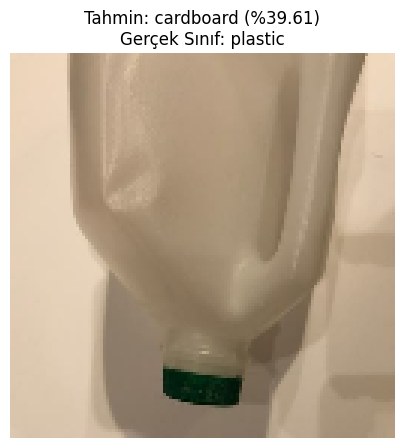

In [ ]:
plt.figure(figsize=(5,5))
plt.imshow(img.numpy().astype("uint8"))
plt.axis("off")
plt.title(
    f"Tahmin: {class_names[pred_class]} (%{confidence:.2f})\n"
    f"Gerçek Sınıf: {class_names[true_label]}"
)

plt.savefig("images/sample_prediction.png", dpi=200, bbox_inches="tight")
plt.show()
